# Parking Meter Availablity Prediction

##### Yuxiao Zhao, Smart Columbus

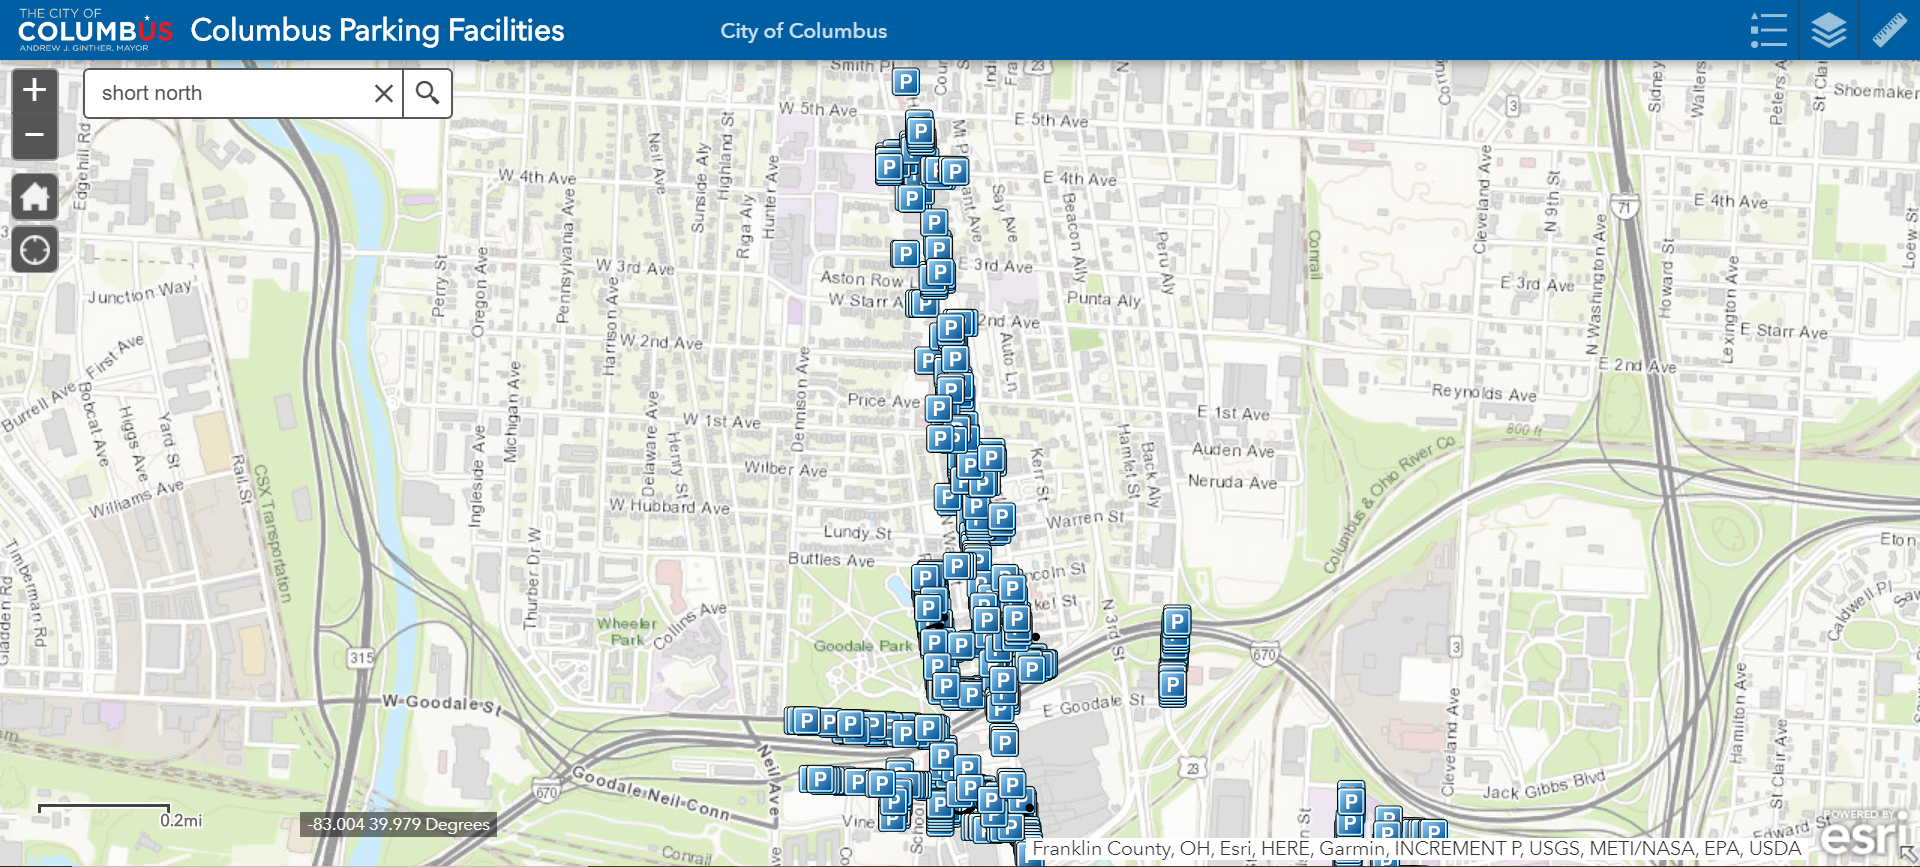

### Overview
- __Main Goal__: Predict the parking meter availablity by street sub-blocks using the historic parking data in the Short North, Columbus
- __Datasets__: IPS [parking meter transaction data from 2015 to 2017](https://discovery.smartcolumbusos.com/dataset/ips_group/7ab08634_3eda_4b05_a754_5eb6cab31326), [parking meter inventory data (locations of meters)](https://discovery.smartcolumbusos.com/dataset/ips_group/d9b11b8f_67f3_48c4_8831_0f22d93166ce)
- __Methods__: Long Short Term Memory (LSTM) -- a Recurrent Neural Network (RNN) used in time series prediction in Deep Learning

### Preprocessing of the datasets
- query the Smart Columbus Operating System API https://data.smartcolumbusos.com/api/v1/query?_format=csv
- clear the dataset (exclude the afterhours, 8am - 10pm Mon-Sat only)
- convert the parking transactions' start & end time to the vailability per 30 minutes for each meter
    - e.g., 8:00-8:30 am Meter A is available, 8:30-9:00 am Meter B is not available
- aggregate by street sub-blocks
- details see another notebook ([Parking Meter Availabillity Preprocessing & Analysis.ipynb](https://nbviewer.jupyter.org/github/kldyzyx/parking-services/blob/master/Parking%20Meter%20Availabillity%20Preprocessing%20%26%20Analysis.ipynb))

*** Street sub-blocks are sub areas divided by streets. There are 92 street sub-blocks in the Short North Area.
<img src="parking%20meter%20locations.png" alt="Drawing" style="width: 600px;"/>

#### Import the needed libraries

In [2]:
import requests 
import plotly.offline as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from numpy import concatenate
from datetime import datetime
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Masking
from keras.models import load_model
py.init_notebook_mode(connected=False)

### Prepare the data for the model 
- __for one sub-block only, train a model for each sub-block__
- __transform to time series that can be used in LSTM model for prediction__ 
- __use the last 25 hours to predict the next half hour availablity, from 0 (no available meter) to 1 (all available)__ 
    - e.g.:
        - use the 8:00 am (Nov 11) -9:00 am (Nov 12) data to predict 9:00 am-9:30 am (Nov 12),
        - 9:00 am (Nov 11) - 10:00am (Nov 12) data to predict 10:00 am-10:30 am (Nov 12), etc.
        - note: 10pm to 8am data are not considered, so actually 15 hours back in the past are used to predict
- __prepare the train, validation and test set for the model__

In [3]:
trans_129 = pd.DataFrame()
for year in [2015,2016,2017]:
    for month in list(range(1,13)):
        year_month = str(year)+'_'+str(month)
        trans_withBlock_group = pd.read_csv('parking_meter/parking_meter/'+ str(year)+'_'+str(month) +'_' +'trans_withBlock_group.csv').drop(columns = ['Unnamed: 0'])
        trans_129_month = trans_withBlock_group[(trans_withBlock_group['str_block_id'] == '129_HIGH ST N')].reset_index(drop=True)
        trans_129_month['timestamp'] = pd.to_datetime(trans_129_month['timestamp'])
        trans_129_month = trans_129_month.set_index("timestamp")
        trans_129_month['availableRate'] = trans_129_month['available']/trans_129_month['pole']
        trans_129_month = trans_129_month.between_time('08:00', '22:00', include_start = True, include_end = False) 
        trans_129_month = trans_129_month[(trans_129_month.index.dayofweek != 6)] # exclude sunday
        trans_129 = trans_129.append(trans_129_month)

In [4]:
weather_new = pd.read_csv('weather/weather_data_2015_2017.csv', index_col = 0)
timezone = '|'.join(['-05:00', '-04:00'])
weather_new['timestamp'] = pd.to_datetime(weather_new['time'].str.replace(timezone,''), format = "%Y-%m-%d %H:%M:%S")
weather_new = weather_new.drop_duplicates(subset='timestamp', keep='first').reset_index(drop=True)
weather_new = weather_new.set_index("timestamp").resample("30T").asfreq().ffill().reset_index()

In [5]:
trans_129_weather = trans_129.join(weather_new.set_index('timestamp'), on = 'timestamp')
trans_129_weather.iloc[:,6:11].head()

availableRate  apparent_temperature  cloud_cover  \
timestamp                                                               
2015-01-01 08:00:00            1.0                 11.49          0.0   
2015-01-01 08:30:00            1.0                 11.49          0.0   
2015-01-01 09:00:00            1.0                 13.54          0.0   
2015-01-01 09:30:00            1.0                 13.54          0.0   
2015-01-01 10:00:00            1.0                 16.12          0.0   

                     dew_point  humidity  
timestamp                                 
2015-01-01 08:00:00       9.89      0.67  
2015-01-01 08:30:00       9.89      0.67  
2015-01-01 09:00:00      11.70      0.65  
2015-01-01 09:30:00      11.70      0.65  
2015-01-01 10:00:00      12.79      0.59

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = trans_129_weather.iloc[:,6]
values = dataset.values.reshape(-1, 1)
timelags = 30
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, timelags, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[1:-1], axis=1, inplace=True)
reframed.head()

var1(t-30)  var1(t-29)  var1(t-28)  var1(t-27)  var1(t-26)  var1(t-25)  \
30         1.0         1.0         1.0         1.0         1.0         1.0   
31         1.0         1.0         1.0         1.0         1.0         1.0   
32         1.0         1.0         1.0         1.0         1.0         1.0   
33         1.0         1.0         1.0         1.0         1.0         1.0   
34         1.0         1.0         1.0         1.0         1.0         1.0   

    var1(t-24)  var1(t-23)  var1(t-22)  var1(t-21)    ...     var1(t-9)  \
30         1.0         1.0         1.0         1.0    ...           1.0   
31         1.0         1.0         1.0         1.0    ...           1.0   
32         1.0         1.0         1.0         1.0    ...           1.0   
33         1.0         1.0         1.0         1.0    ...           1.0   
34         1.0         1.0         1.0         1.0    ...           1.0   

    var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  \
30        1.0        1.0   1.000000   1.000000   1.000000   1.000000   
31        1.0        1.0   1.000000   1.000000   1.000000   0.833333   
32        1.0        1.0   1.000000   1.000000   0.833333   0.833333   
33        1.0        1.0   1.000000   0.833333   0.833333   0.666667   
34        1.0        1.0   0.833333   0.833333   0.666667   0.416667   

    var1(t-2)  var1(t-1)   var1(t)  
30   0.833333   0.833333  0.666667  
31   0.833333   0.666667  0.416667  
32   0.666667   0.416667  0.166667  
33   0.416667   0.166667  0.083333  
34   0.166667   0.083333  0.250000  

[5 rows x 31 columns]

__Divide the dataset as train (about 18 months), validation (9 months) and test set (9 months).__

In [7]:
values = reframed.values
timevars = timelags
# timevars = 5
n_train_hours = len(values)//2
n_test_hours = len(values)//4
train = values[:n_train_hours, :]
test = values[n_train_hours:(n_train_hours + n_test_hours), :]
test_split = values[(n_train_hours + n_test_hours):, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
test_split_X, test_split_y = test_split[:, :-1], test_split[:, -1]

# train_X, train_y = train[:, :-timevars], train[:, -timevars:]
# test_X, test_y = test[:, :-timevars], test[:, :-timevars]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timevars, 1))
test_X = test_X.reshape((test_X.shape[0], timevars, 1))
test_split_X = test_split_X.reshape((test_split_X.shape[0], timevars, 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape,test_split_X.shape, test_split_y.shape)

(13131, 30, 1) (13131,) (6565, 30, 1) (6565,) (6566, 30, 1) (6566,)


### Train the prediction model

__Design and train the network.__

In [8]:
# # design network
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')
# # fit network
# history = model.fit(train_X, train_y, epochs=100, batch_size= 150, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

In [9]:
# # save model to single file
# model.save('lstm_model_3years_129.h5')

In [10]:
# load pretained model
model = load_model('lstm_model_3years_129.h5')

### Make predictions on the test set

In [11]:
# # make a prediction
test_split_X = test_split_X.reshape((test_split_X.shape[0], test_split_X.shape[1],1))
yhat = model.predict(test_split_X)
test_split_X = test_split_X.reshape((test_split_X.shape[0], test_split_X.shape[1]))
# # invert scaling for forecast
inv_yhat = concatenate((yhat, test_split_X[:, :-1]), axis=1)
inv_yhat.shape
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_split_y = test_split_y.reshape((len(test_split_y), 1))
inv_y = concatenate((test_split_y, test_split_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [12]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=trans_129_weather.index[(30+n_train_hours + n_test_hours):], y=inv_y.reshape(test_split_y.shape[0]), name="actual",
                         line_color='orange'))
fig.add_trace(go.Scatter(x=trans_129_weather.index[(30+n_train_hours + n_test_hours):], y=inv_yhat, name="predicted",
                         line_color='deepskyblue'))

fig.update_layout(title_text='Availablity of parking meters',
                  xaxis_rangeslider_visible=True)
fig.show()

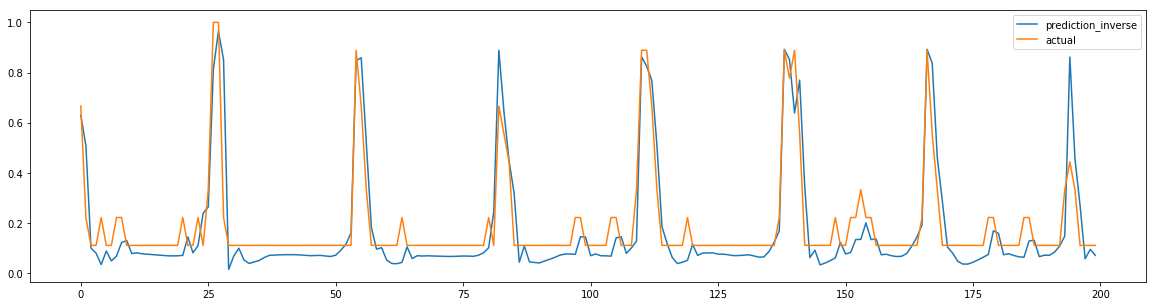

In [14]:
plt.figure(figsize=(20,5))
plt.plot(inv_yhat[100:300], label = 'prediction_inverse')
plt.plot(inv_y[100:300], label = 'actual')
plt.legend()
plt.show()

### Evaluate the model

In [16]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Baseline RMSE: %.3f' % sqrt(mean_squared_error(inv_y[1:], inv_y[:-1])))
print('%.2f %% improved compared to the baseline.'%(100*(sqrt(mean_squared_error(inv_y[1:], inv_y[:-1])) - rmse)/sqrt(mean_squared_error(inv_y[1:], inv_y[:-1]))))

Test RMSE: 0.113
Baseline RMSE: 0.167
32.19 % improved compared to the baseline.
